# Vehicle Fuel Efficiency Prediction using TensorFlow

## Table of Contents
1. Introduction & Goals
2. Import Libraries and Dataset
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing
5. Model Development
6. Model Training and Evaluation
7. Hyperparameter Tuning
8. Results and Interpretation
9. Conclusions and Next Steps

## 1. Introduction & Goals

**Objective:**
Predict vehicle fuel efficiency (Miles Per Gallon, MPG) based on several vehicle features using TensorFlow Neural Network regression.

**Dataset Source:** [UCI Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

**Dataset Features:**
- Cylinders
- Displacement
- Horsepower
- Weight
- Acceleration
- Model Year
- Origin

## 2. Import Libraries and Dataset

In [2]:
# Importing necessary libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visual style setup
sns.set(style="whitegrid")

## 3. Exploratory Data Analysis (EDA)

In [3]:
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features 
y = auto_mpg.data.targets

df = pd.concat([X, y], axis=1)
df.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0


In [4]:
# Data types, missing values, and structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   horsepower    392 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model_year    398 non-null    int64  
 6   origin        398 non-null    int64  
 7   mpg           398 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


In [5]:
# Statistical summary
df.describe()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
count,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,193.425879,5.454774,104.469388,2970.424623,15.568090,76.010050,1.572864,23.514573
std,104.269838,1.701004,38.491160,846.841774,2.757689,3.697627,0.802055,7.815984
min,68.000000,3.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,104.250000,4.000000,75.000000,2223.750000,13.825000,73.000000,1.000000,17.500000
50%,148.500000,4.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,23.000000
75%,262.000000,8.000000,126.000000,3608.000000,17.175000,79.000000,2.000000,29.000000
max,455.000000,8.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [6]:
# Check for missing values
df.isnull().sum()

displacement    0
cylinders       0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64

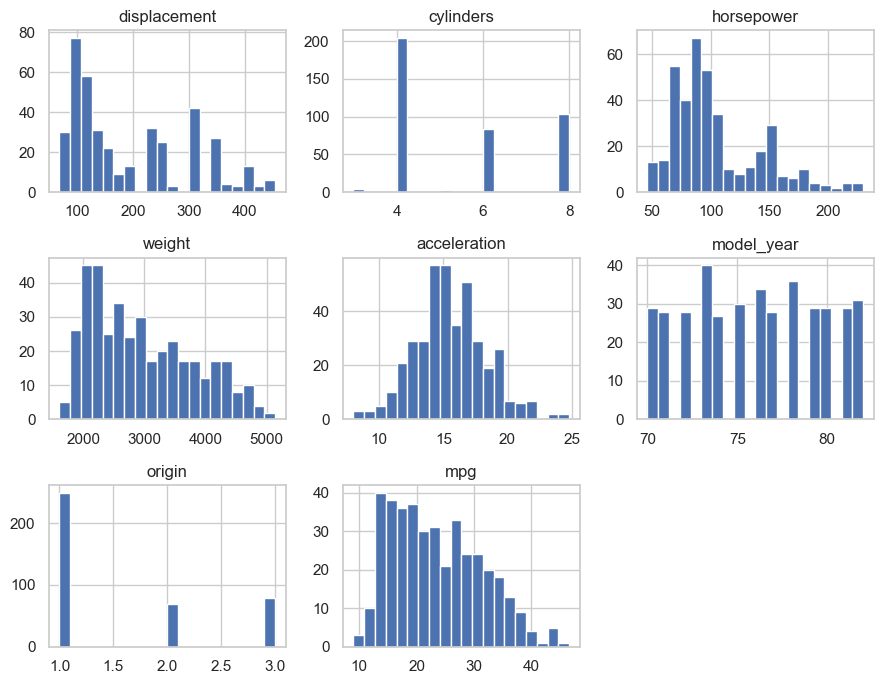

In [7]:
# Histogram for all numeric features
df.hist(bins=20, figsize=(9,7))
plt.tight_layout()
plt.show()

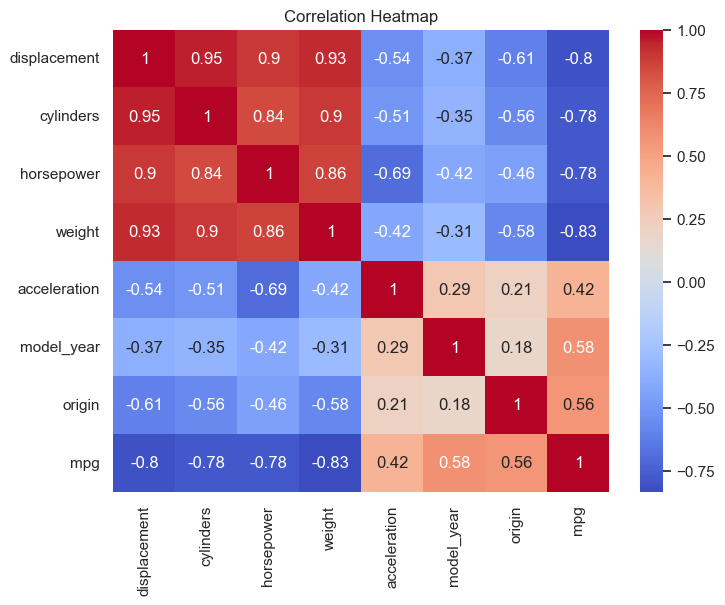

In [8]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

## 4. 🔧 Data Preprocessing

Handling:
- Missing values.
- Encoding categorical features.
- Scaling numerical features.
- Splitting data into training and test sets.

### Missing values

The `horsepower` column contains missing entries. They were replaced with the median value of the column to maintain data integrity and minimize bias.

In [9]:
# horsepower column contain missing values
df[df.isnull().any(axis=1)]

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
32,98.0,4,NaN,2046,19.0,71,1,25.0
126,200.0,6,NaN,2875,17.0,74,1,21.0
330,85.0,4,NaN,1835,17.3,80,2,40.9
336,140.0,4,NaN,2905,14.3,80,1,23.6
354,100.0,4,NaN,2320,15.8,81,2,34.5
374,151.0,4,NaN,3035,20.5,82,1,23.0


In [10]:
# Imputing missing values with median
print(f"Horsepower median: {df['horsepower'].median()}")
df["horsepower"] = df['horsepower'].fillna(df['horsepower'].median())

Horsepower median: 93.5


### Encoding categorical features, scaling and splitting the data

The `origin` column represents the geographical origin of vehicles and needs to be encoded into numeric values using one-hot encoding.

Features have been scaled using `MinMaxScaler`, which scales each feature to a given range, typically [0, 1]. After scaling, the dataset has been split into training (80%) and test sets (20%) to evaluate the model's predictive performance on unseen data.


In [11]:
ct = make_column_transformer(
    (MinMaxScaler(), ["displacement", "cylinders", "horsepower", "weight", "acceleration", "model_year"]),
    (OneHotEncoder(handle_unknown="ignore"), ["origin"] ))

In [12]:
# Split into Train and Test Sets
X = df.drop('mpg', axis=1)
y = df["mpg"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ct.fit(X_train)

X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

## 5. Model Development

In [15]:
# Defining the neural network model structure
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_normal.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Model compilation
model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Model summary
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                320       
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


## 6. Model Training and Evaluation

In [17]:
history_1 = model_1.fit(
    X_train_normal, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
18/18 [==============================] - 1s 19ms/step - loss: 592.2291 - mae: 22.9580 - val_loss: 636.8939 - val_mae: 23.9554
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 577.5250 - mae: 22.6187 - val_loss: 621.6191 - val_mae: 23.6178
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 561.6744 - mae: 22.2390 - val_loss: 604.6655 - val_mae: 23.2344
Epoch 4/10
18/18 [==============================] - 0s 5ms/step - loss: 543.3942 - mae: 21.7934 - val_loss: 584.8728 - val_mae: 22.7774
Epoch 5/10
18/18 [==============================] - 0s 4ms/step - loss: 522.0529 - mae: 21.2561 - val_loss: 561.1852 - val_mae: 22.2181
Epoch 6/10
18/18 [==============================] - 0s 5ms/step - loss: 496.7630 - mae: 20.5985 - val_loss: 533.1038 - val_mae: 21.5365
Epoch 7/10
18/18 [==============================] - 0s 5ms/step - loss: 467.7297 - mae: 19.8187 - val_loss: 501.3527 - val_mae: 20.7402
Epoch 8/10
18/18 [=============================

In [19]:
# Predictions
y_pred_1 = model_1.predict(X_test_normal).flatten()

# Metrics calculations
mae_1 = mean_absolute_error(y_test, y_pred_1)
mse_1 = mean_squared_error(y_test, y_pred_1)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_test, y_pred_1)

# Print results
print(f"Mean Absolute Error (MAE): {mae_1:.3f}")
print(f"Mean Squared Error (MSE): {mse_1:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_1:.3f}")
print(f"R² Score: {r2_1:.3f}")

3/3 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 15.918
Mean Squared Error (MSE): 328.561
Root Mean Squared Error (RMSE): 18.126
R² Score: -5.111


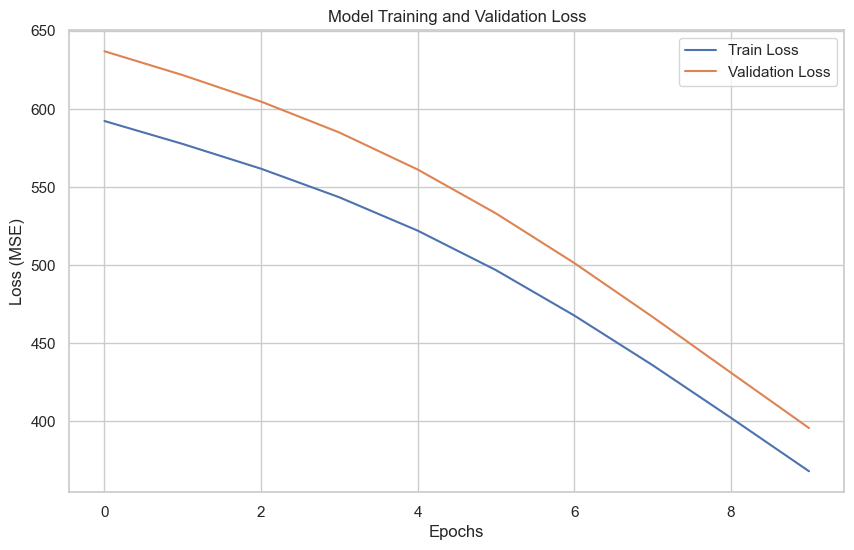

In [20]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Training and Validation Loss (Model 1)')
plt.legend()
plt.show()

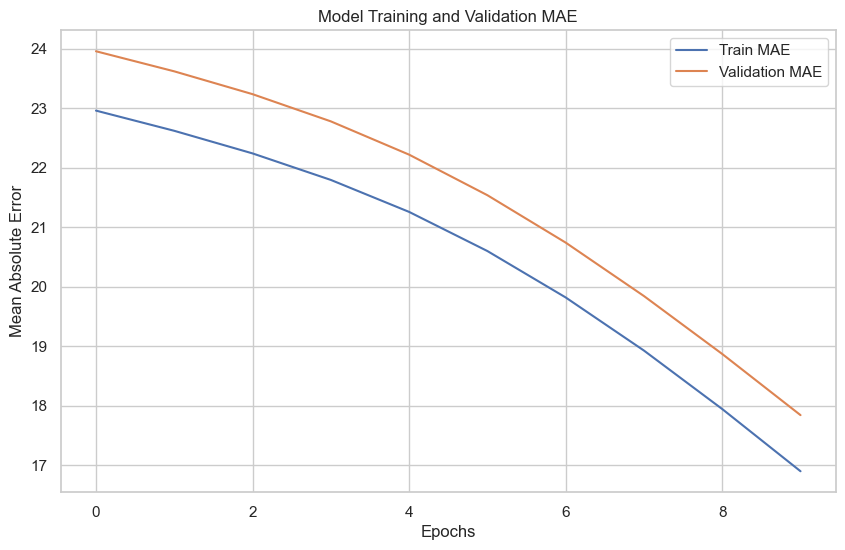

In [21]:
# Plot training & validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history_1.history['mae'], label='Train MAE')
plt.plot(history_1.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Model Training and Validation MAE (Model 1)')
plt.legend()
plt.show()

## 7. Hyperparameter Tuning

### Model 2

In [22]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_normal.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                640       
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_2 = model_2.fit(
    X_train_normal, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
18/18 [==============================] - 1s 15ms/step - loss: 589.2946 - mae: 22.9146 - val_loss: 618.5495 - val_mae: 23.5715
Epoch 2/10
18/18 [==============================] - 0s 4ms/step - loss: 540.2482 - mae: 21.7657 - val_loss: 553.7803 - val_mae: 22.1091
Epoch 3/10
18/18 [==============================] - 0s 4ms/step - loss: 459.4065 - mae: 19.7244 - val_loss: 451.7920 - val_mae: 19.5500
Epoch 4/10
18/18 [==============================] - 0s 4ms/step - loss: 346.9830 - mae: 16.2957 - val_loss: 318.3978 - val_mae: 15.4944
Epoch 5/10
18/18 [==============================] - 0s 4ms/step - loss: 221.6928 - mae: 12.1141 - val_loss: 191.5124 - val_mae: 11.5775
Epoch 6/10
18/18 [==============================] - 0s 4ms/step - loss: 135.1117 - mae: 9.6498 - val_loss: 121.3630 - val_mae: 9.4076
Epoch 7/10
18/18 [==============================] - 0s 4ms/step - loss: 100.1716 - mae: 8.6722 - val_loss: 89.1618 - val_mae: 7.9679
Epoch 8/10
18/18 [==============================] - 

In [24]:
y_pred_2 = model_2.predict(X_test_normal).flatten()

# Metrics calculations
mae_2 = mean_absolute_error(y_test, y_pred_2)
mse_2 = mean_squared_error(y_test, y_pred_2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test, y_pred_2)

# Print results
print(f"Mean Absolute Error (MAE): {mae_2:.3f}")
print(f"Mean Squared Error (MSE): {mse_2:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2:.3f}")
print(f"R² Score: {r2_2:.3f}")

3/3 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 4.582
Mean Squared Error (MSE): 29.859
Root Mean Squared Error (RMSE): 5.464
R² Score: 0.445


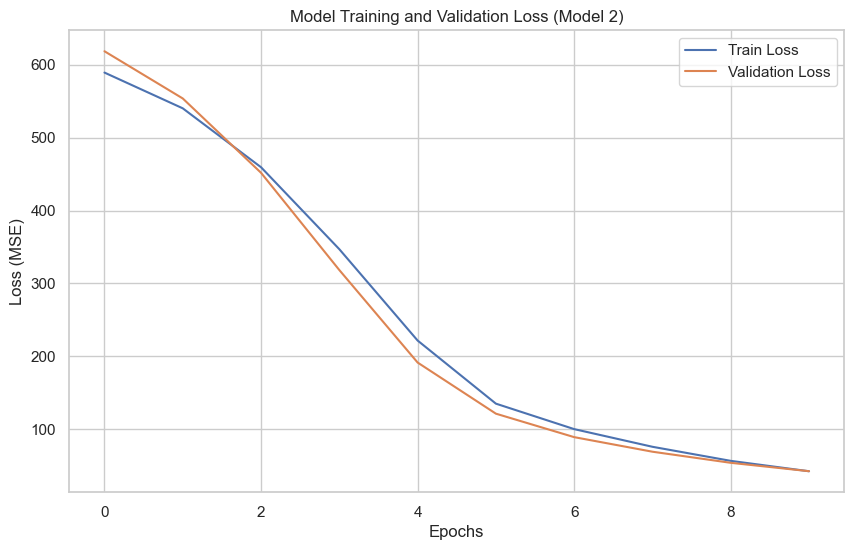

In [25]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Training and Validation Loss (Model 2)')
plt.legend()
plt.show()

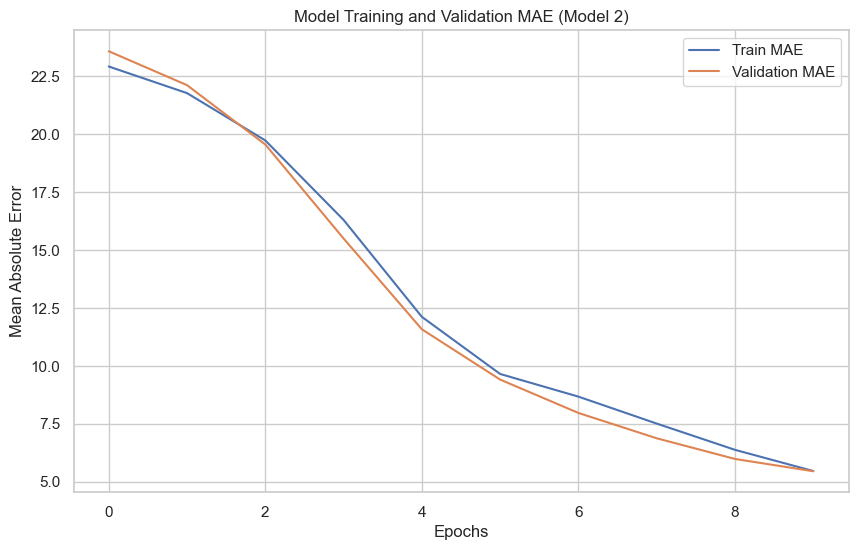

In [26]:
# Plot training & validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history_2.history['mae'], label='Train MAE')
plt.plot(history_2.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Model Training and Validation MAE (Model 2)')
plt.legend()
plt.show()

### Model 3

In [27]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_normal.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                640       
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_3 = model_3.fit(
    X_train_normal, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 599.2634 - mae: 23.1880 - val_loss: 631.6909 - val_mae: 23.8994
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 562.3077 - mae: 22.3356 - val_loss: 585.9910 - val_mae: 22.8929
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 503.3565 - mae: 20.8959 - val_loss: 506.4989 - val_mae: 21.0090
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 405.5531 - mae: 18.1884 - val_loss: 378.5054 - val_mae: 17.5187
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 270.5658 - mae: 13.7624 - val_loss: 231.0675 - val_mae: 12.8089
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 156.2623 - mae: 10.0460 - val_loss: 135.6280 - val_mae: 9.8432
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 110.8897 - mae: 8.9706 - val_loss: 97.8547 - val_mae: 8.2991
Epoch 8/100
18/18 [=========================

18/18 [==============================] - 0s 8ms/step - loss: 8.3432 - mae: 2.1190 - val_loss: 8.8788 - val_mae: 2.2638
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 8.2091 - mae: 2.0906 - val_loss: 8.8108 - val_mae: 2.2491
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 8.1169 - mae: 2.0860 - val_loss: 8.7499 - val_mae: 2.2294
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 8.1983 - mae: 2.1122 - val_loss: 8.6606 - val_mae: 2.2499
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 8.0206 - mae: 2.0864 - val_loss: 8.5019 - val_mae: 2.2363
Epoch 67/100
18/18 [==============================] - 0s 9ms/step - loss: 7.9062 - mae: 2.0591 - val_loss: 8.4040 - val_mae: 2.2166
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 7.9173 - mae: 2.0580 - val_loss: 8.3997 - val_mae: 2.1977
Epoch 69/100
18/18 [==============================] - 0s 3ms/step - loss: 7.8531 - mae: 2

In [29]:
y_pred_3 = model_3.predict(X_test_normal).flatten()

# Metrics calculations
mae_3 = mean_absolute_error(y_test, y_pred_3)
mse_3 = mean_squared_error(y_test, y_pred_3)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test, y_pred_3)

# Print results
print(f"Mean Absolute Error (MAE): {mae_2:.3f}")
print(f"Mean Squared Error (MSE): {mse_2:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2:.3f}")
print(f"R² Score: {r2_2:.3f}")

3/3 [==============================] - 0s 2ms/step
Mean Absolute Error (MAE): 4.582
Mean Squared Error (MSE): 29.859
Root Mean Squared Error (RMSE): 5.464
R² Score: 0.445


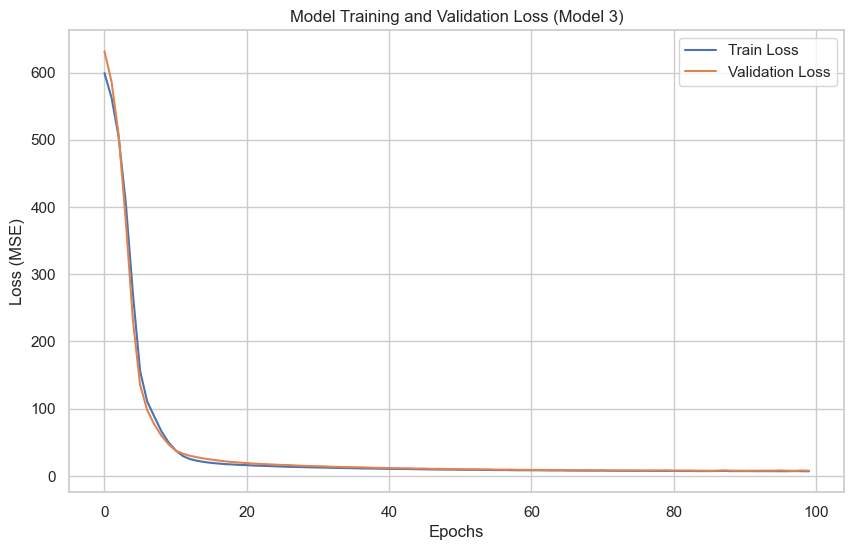

In [30]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model Training and Validation Loss (Model 3)')
plt.legend()
plt.show()

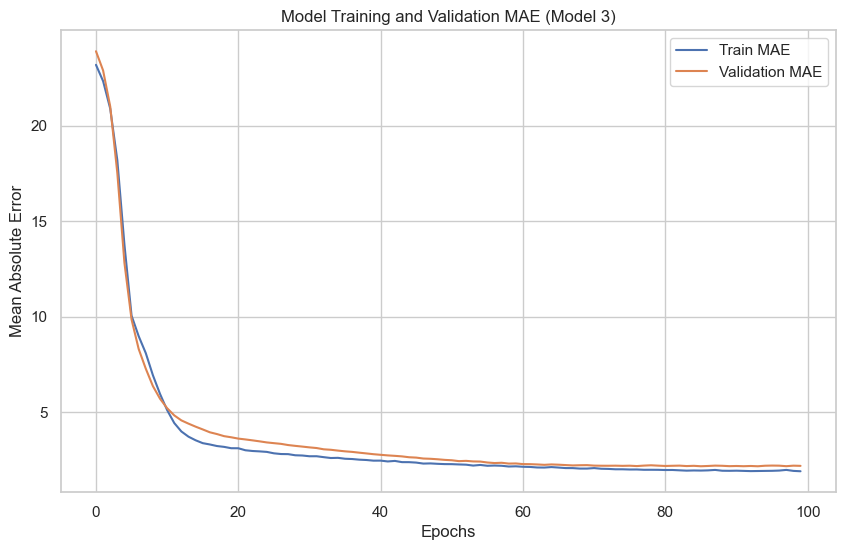

In [31]:
# Plot training & validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history_3.history['mae'], label='Train MAE')
plt.plot(history_3.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Model Training and Validation MAE (Model 3)')
plt.legend()
plt.show()

## 8. Results and Interpretation

In [32]:
model_results = [["model_1", mae_1, mse_1, rmse_1, r2_1],
                 ["model_2", mae_2, mse_2, rmse_2, r2_2],
                 ["model_3", mae_3, mse_3, rmse_3, r2_3]]

all_results = pd.DataFrame(model_results, columns=["model", "mae", "mse", "rmse", "R^2"])
all_results

,model,mae,mse,rmse,R^2
0,model_1,15.917788,328.560723,18.126244,-5.110888
1,model_2,4.581687,29.859187,5.464356,0.444650
2,model_3,1.706633,5.096396,2.257520,0.905212


### 📈 Results Interpretation

- **Model 1** (basic architecture) performed poorly with an R² score of -5.11, indicating no useful learning.
- **Model 2** significantly improved the performance by increasing hidden layers and neurons.
- **Model 3**, with more training epochs, achieved the best performance:
  - MAE: ~1.7 MPG — meaning the average prediction error is around 1.7 miles per gallon.
  - R²: 0.91 — 91% of the variance in fuel efficiency is explained by the model.

This indicates that deeper networks and longer training helped the model generalize better.


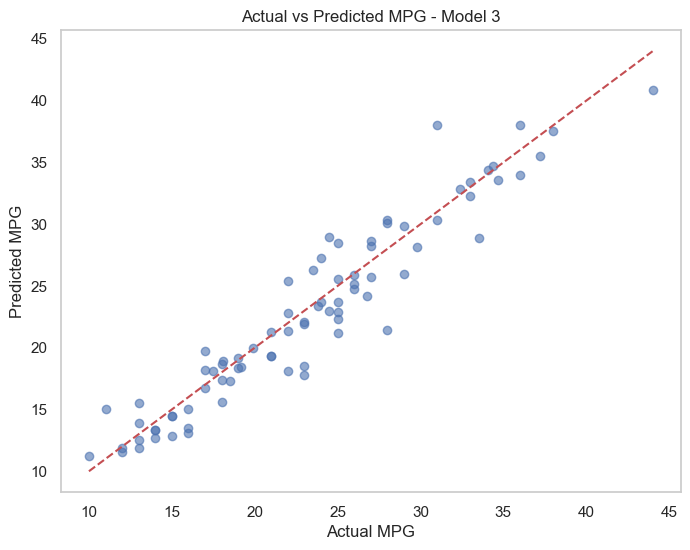

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_3, alpha=0.6)
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Actual vs Predicted MPG - Model 3")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid()
plt.show()

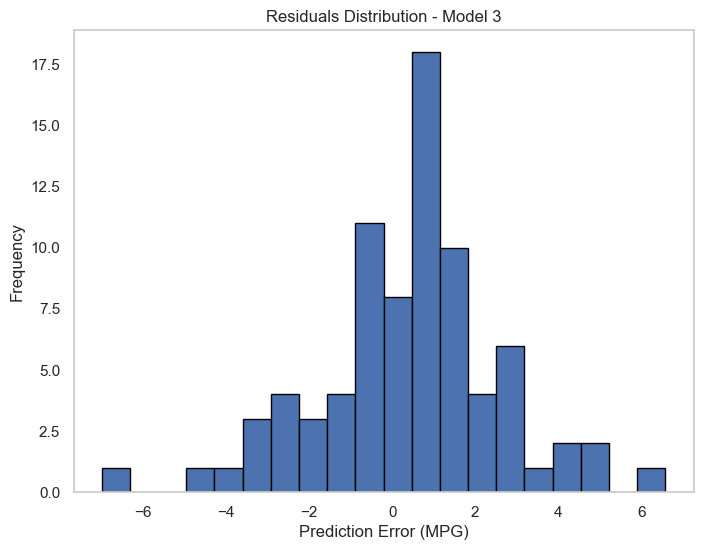

In [34]:
residuals = y_test - y_pred_3
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title("Residuals Distribution - Model 3")
plt.xlabel("Prediction Error (MPG)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

* The residuals are mostly centered around 0, which is a very good sign.
* The model is generally unbiased — it's not consistently overpredicting or underpredicting.
* The plot is roughly symmetrical and looks somewhat normal (bell-shaped). This suggests that the errors are randomly distributed, which is an assumption of good regression models (especially for linear-like behavior). No obvious skewness to the left or right means that large over/underestimations are not systematic.
* Most residuals fall in the range of about -2 to +2, which shows tight clustering of predictions around the true values — indicating high accuracy.

## 9. Conclusions and Next Steps

### 🧾 Conclusions

- A neural network regression model can effectively predict vehicle fuel efficiency based on engine and car specs.
- Model performance improved significantly with:
  - More hidden layers and neurons.
  - Increased training epochs.

- Final model (Model 3) achieved an excellent R² score of **0.91**, showing strong predictive ability.

### 🔮 Next Steps

- Integrate additional preprocessing steps like:
  - Handling categorical features with embeddings instead of one-hot.
  - Feature selection or engineering (e.g., `power_to_weight_ratio`).
- Introduce **early stopping** or **learning rate scheduling** to optimize training.
- Experiment with **other optimizers** (e.g., RMSprop, SGD) and **loss functions**.
- Try **Keras Tuner** for automated hyperparameter optimization.
- Deploy the model using Flask/Streamlit to create a simple web app.

## 🔬 Comparison with Scientific Paper

To validate and benchmark this project, I compared my approach to a peer-reviewed paper:

> **Title**: Artificial Neural Network Model for Prediction of Fuel Consumption of a Car  
> **Journal**: IJAISR, 2020  
> [Link (PDF)](http://ijeais.org/wp-content/uploads/2020/11/IJAISR201102.pdf)

### ✅ Summary of Differences

| Feature                     | My Project                                   | IJAISR Paper (2020)                        |
|----------------------------|----------------------------------------------|--------------------------------------------|
| **Dataset**                | UCI Auto MPG                                  | UCI Auto MPG                               |
| **Tool/Framework**         | TensorFlow / Keras (Python)                  | JustNN (GUI-based tool)                    |
| **Preprocessing**          | Handled missing values, MinMaxScaler         | Auto-scaled in JustNN                      |
| **Model Structure**        | Multiple tested: 1H-32, 2H-64-32              | Fixed: 2 hidden layers with 3 neurons total |
| **Epochs**                 | 10–100 (manually tuned)                      | 7683 epochs                                |
| **Evaluation Metrics**     | MAE, MSE, RMSE, R²                           | Accuracy (classification-style)            |
| **Best R²**                | 0.91 (Model 3)                                | Not reported                               |
| **Hyperparameter Tuning**  | Manual & iterative                           | Trial and error via GUI                    |
| **Reproducibility**        | Fully reproducible Jupyter notebook          | Limited (no code provided)                 |

### 📌 Interpretation

- My approach achieved significantly **better performance** with **fewer epochs**.
- Using **code-based tools** makes the work more robust, flexible, and production-ready.
- Unlike the paper, I used appropriate **regression metrics** (e.g. R², MAE).
- The project goes beyond black-box modeling — showing **technical fluency** and **ML best practices**.

